# Generative Adversarial Networks (GANs)
Generative adversarial networks are neural networks which is able to generate materials such as - images, music, speech or text, which is similar to what humans are able to produce. It is an active topic of research in recent times. In this tutorial, I will show you how GANs work and also will teach you to implement generative models.

GANs consists of 2 neural networks - one trained to generate data and the other one is trained to distinguish fake data from real data. The latter one provides the adversarial nature of the model.

## Difference between Discriminative and Generative models
Discriminative models are used for most supervised classification or regression problems. For example - you have used discriminative models to classify labelled images of handwritten digits from 0 to 9.

Generative models like GANs are trained to describe how a dataset is generated in terms of probabilistic model. By sampling from a generative model, you are able to generate new data. On the other hand, discriminative models are used for supervised learning. Generative models are often used with unlabelled dataset and can be seen as a form of unsupervised learning. We can actually use the dataset of handwriiten digits to train a generative model to generate new digits. During training, some algorithms are used to adjust the model's parameters to minimize a loss function and learn the probability distribution of the training set, and the model trained is used to generate new samples. To output new samples, generative models usually consider a stochastic, or random element that influences the samples generated by the model. The random samples used to drive the generator are obtained from a latent spae in which the vectors represent a kind of compressed form of the generative samples. Generative models can also be used for labelled datasets, but in general, discriminative models work better for classification. GANs have recieved a lot of attention in recent times, but they are not the only architecture that can be used as a generative model. There are other generative model architectures such as - Boltzmann machines, variational autoencoders, Hidden markov models, GPT-2, etc.

In [4]:
%pip install --upgrade certifi

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.1 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.9 MB/s eta 0:00:00-:--:--
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

Random generator seed ensures that the experiment can be replicated in any macine. The number 111 represents the random seed used to initialize the random number generator which is later used to initialize neural network's weights.

In [7]:
torch.manual_seed(111)

In [8]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

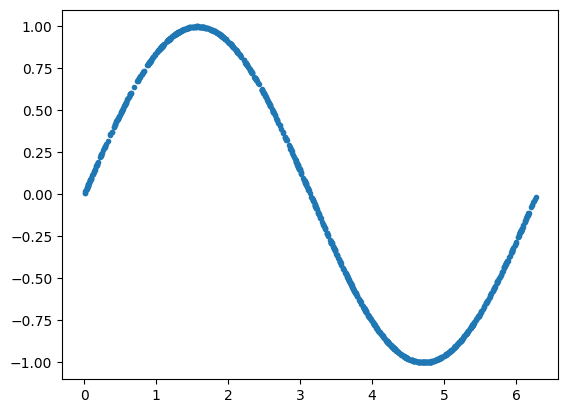

In [9]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

## Prepare the training data

In [14]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

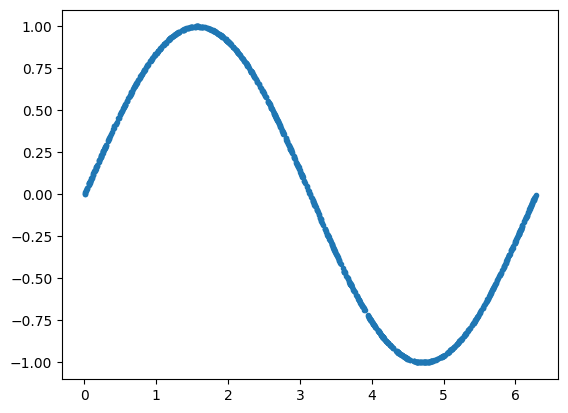

In [15]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## Implementing the discriminator

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), # sigmoid used to determine how accurate the training data is to the generated image
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [20]:
discriminator = Discriminator()

## Implementing the Generator

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## Training the model

In [22]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [23]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.20249870419502258
Epoch: 0 Loss G.: 2.4545137882232666
Epoch: 10 Loss D.: 0.5875766277313232
Epoch: 10 Loss G.: 1.0955071449279785
Epoch: 20 Loss D.: 0.6285133957862854
Epoch: 20 Loss G.: 1.0201280117034912
Epoch: 30 Loss D.: 0.6346614360809326
Epoch: 30 Loss G.: 1.1163946390151978
Epoch: 40 Loss D.: 0.6367043852806091
Epoch: 40 Loss G.: 0.7959602475166321
Epoch: 50 Loss D.: 0.7143562436103821
Epoch: 50 Loss G.: 0.6594240665435791
Epoch: 60 Loss D.: 0.686298131942749
Epoch: 60 Loss G.: 0.9113631248474121
Epoch: 70 Loss D.: 0.704951822757721
Epoch: 70 Loss G.: 0.6907016634941101
Epoch: 80 Loss D.: 0.6634458303451538
Epoch: 80 Loss G.: 0.7214133739471436
Epoch: 90 Loss D.: 0.7032732367515564
Epoch: 90 Loss G.: 0.683447003364563
Epoch: 100 Loss D.: 0.7429314851760864
Epoch: 100 Loss G.: 0.6433516144752502
Epoch: 110 Loss D.: 0.6394466757774353
Epoch: 110 Loss G.: 0.7919858694076538
Epoch: 120 Loss D.: 0.6730875968933105
Epoch: 120 Loss G.: 0.9720854163169861
Epoch: 130

## Check the sample generated

In [25]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

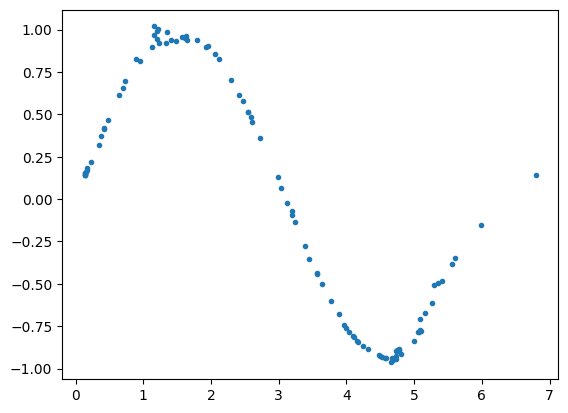

In [26]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")